# 03_anchor_generator
**This file used to generate anchors for UECFOOD100 dataset through kmeans.
Distance here is not Euclidean distance but IoU (Intersection over Union) in
accordance with original yolo-v2 paper.**

In [11]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

**k-means clustering**:  
- Input: k, set of points [w1,h1], [w2,h2], [w3, h3], ..., [wn, hn] 
- Place centroids c1, ..., ck at random locations (randomly select k [w,h] among input img wh)
- Repeat until convergence:
    - for each point [wi,hi]:
        - find nearest centroid cj. (np.argmin(new_distances, axis=1))
        - assign the point [wi,hi] to cluster j.
    - for each cluster j=1, ...,k: (update centroids)
        - new centroid cj=mean of all points [wi,hi] assigned to cluster j in previous step
        $\frac{1}{n_j}\sum\limits_{x_i\rightarrow c_j}x_i(a)$  (a means a particular attribute in this case a is wh[i])
- Stop when none of the cluster assignments change

In [12]:
def kmeans(wh, centroids, anchor_txt):
    num = wh.shape[0]  # total number of different wh pairs
    k, dim = centroids.shape
    iter = 0
    old_distances = np.zeros((num, k))
    _assignments = -np.ones(num)

    # iterate until
    while True:
        new_distances = []
        iter += 1
        for i in range(num):
            distance = 1 - IoU(wh[i], centroids)  # high IoU represents low distance
            new_distances.append(distance)
        new_distances = np.array(new_distances)
        print('Iter {}: distances: {}'.format(iter, np.sum((np.abs(old_distances - new_distances)))))

        # for each input img assign a centroid (select the closed one)
        assignments = np.argmin(new_distances, axis=1)
        if (assignments == _assignments).all():
            print('final centroids =', centroids)
            save_anchors(centroids, anchor_txt, wh_in_mobilenet)
            return centroids
        else:
            centroid_sums = np.zeros((k, dim), np.float)
            for i in range(num):
                centroid_sums[assignments[i]] += wh[i]  # sum up attribute
            for j in range(k):
                # new centroids
                centroids[j] = centroid_sums[j] / np.sum(assignments == j)

            _assignments = assignments.copy()
            old_distances = new_distances.copy()

In [13]:
def save_anchors(centroids, anchor_txt, wh_in_mobilenet):
    width_in_yolov2 = wh_in_mobilenet[0]
    height_in_yolov2 = wh_in_mobilenet[1]
    with open(anchor_txt, 'w') as file:
        anchors = centroids.copy()
        for i in range(anchors.shape[0]):
            anchors[i][0] *= width_in_yolov2 / 32.
            anchors[i][1] *= height_in_yolov2 / 32.
        widths = anchors[:, 0]
        sorted_indices = np.argsort(widths)  # return the indices that sort tht array
        print('anchors = ', anchors[sorted_indices])

        for i in sorted_indices:
            file.write('%0.2f, %0.2f\n' % (anchors[i, 0], anchors[i, 1]))

In [14]:
def avgIoU(wh, centroids):
    sum = 0.
    for i in range(wh.shape[0]):
        sum += max(IoU(wh[i], centroids))
    return sum / wh.shape[0]

**IoU - Intersection over Union **

In [15]:
def IoU(whi, centroids):
    """ Calculate IoU between current centroids with one in wh array to check if current
    centroids are suitable enough
    :param whi:
    :param centroids:
    :return:
    """
    IOU = []
    for centroid in centroids:
        c_w, c_h = centroid
        w, h = whi
        if c_w >= w and c_h >= h:
            iou = w * h / (c_w * c_h)
        elif c_w >= w and c_h <= h:
            iou = w * c_h / (w * h + (c_w - w) * c_h)
        elif c_w <= w and c_h >= h:
            iou = c_w * h / (w * h + (c_h - h) * c_w)
        else:
            iou = c_w * c_h / (w * h)
        IOU.append(iou)
    return np.array(IOU)

In [16]:
def coordinate2wh(coordinates, uec100_dims):
    coordinates = list(map(float, coordinates))
    w = (coordinates[2] - coordinates[0]) / uec100_dims[0]  # x2-x1
    h = (coordinates[3] - coordinates[1]) / uec100_dims[0]  # y2-y1
    return w, h

In [17]:
def gen_anchors(n_clusters, uec100_dims):
    dataset_disk = '/Volumes/JS/UECFOOD100_448/'
    output_path = dataset_disk + 'generated_anchors_mobilenet'
    train_uec100 = dataset_disk + 'train_uec100.txt'

    if not os.path.exists(output_path):
        os.mkdir(output_path)

    wh = []

    with open(train_uec100, 'r') as file:
        for i, line in enumerate(file):
            if i > 0:
                line = line.rstrip('\n')
                line = line.split(' ')
                coordinates = line[2:]
                w, h = coordinate2wh(coordinates, uec100_dims)
                wh.append([w, h])
        wh = np.array(wh)

        if n_clusters == 0:  # make from 1 to 10 clusters and pick the best one
            avgIou = []
            for n_cluster in range(1, 11):
                anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_cluster))
                # randomly select n_cluster anchors from wh array which contain w,h for each img
                indices = [random.randrange(wh.shape[0]) for i in range(n_cluster)]
                centroids = wh[indices]
                centroids = kmeans(wh, centroids, anchor_txt)
                avgIou.append([n_cluster, avgIoU(wh, centroids)])
            avgIou = np.array(avgIou)
            plt.plot(avgIou[:, 0], avgIou[:, 1])
            plt.scatter(avgIou[:, 0], avgIou[:, 1], c='r')
            plt.xlabel('number of cluster')
            plt.ylabel('average IoU')
            plt.savefig('avg_iou')
            plt.show()
        else:
            anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_clusters))
            # randomly select n_cluster anchors from wh array which contain w,h for each img
            indices = [random.randrange(wh.shape[0]) for i in range(n_clusters)]
            centroids = wh[indices]
            kmeans(wh, centroids, anchor_txt)

        print('Done!')

In [18]:
wh_in_mobilenet = [448, 448]
uec100_dims = [800, 600]  # dataset image width=800, height=600
n_clusters = 0

Iter 1: distances: 3822.7559139567993
Iter 2: distances: 823.7190380027757
final centroids = [[0.76773982 0.55747613]]
anchors =  [[10.74835752  7.80466578]]
Iter 1: distances: 7259.906516564002
Iter 2: distances: 2324.1928677932315
Iter 3: distances: 844.8708404726046
Iter 4: distances: 346.29377911320705
Iter 5: distances: 210.11118658448225
Iter 6: distances: 134.75508854590345
Iter 7: distances: 81.14586530353512
Iter 8: distances: 45.563962645840014
Iter 9: distances: 27.918862006058742
Iter 10: distances: 13.119294993153307
Iter 11: distances: 9.300426610073266
Iter 12: distances: 2.573473708586481
Iter 13: distances: 1.435913575648835
final centroids = [[0.44693924 0.34337108]
 [0.87500036 0.62906273]]
anchors =  [[ 6.25714939  4.80719512]
 [12.2500051   8.80687819]]
Iter 1: distances: 10354.620813003348
Iter 2: distances: 3098.747956083542
Iter 3: distances: 1637.363169146226
Iter 4: distances: 1103.4030293826902
Iter 5: distances: 808.7255534791547
Iter 6: distances: 633.62774

Iter 6: distances: 732.2100459453401
Iter 7: distances: 587.9385231339121
Iter 8: distances: 507.84545353818055
Iter 9: distances: 406.66961738894133
Iter 10: distances: 403.8828855341101
Iter 11: distances: 340.6766317394301
Iter 12: distances: 320.1092616615377
Iter 13: distances: 280.6082487501345
Iter 14: distances: 163.86977786741647
Iter 15: distances: 122.92531981308868
Iter 16: distances: 92.94775161898723
Iter 17: distances: 81.67232240841872
Iter 18: distances: 70.21142704213867
Iter 19: distances: 70.4624131122431
Iter 20: distances: 70.34076062092691
Iter 21: distances: 54.45763016003206
Iter 22: distances: 34.41134472553986
Iter 23: distances: 29.515051685447037
Iter 24: distances: 19.464546666344873
Iter 25: distances: 31.15829170970711
Iter 26: distances: 17.982119832470826
Iter 27: distances: 13.73678905189552
Iter 28: distances: 12.005749020950981
Iter 29: distances: 12.550584626954178
Iter 30: distances: 13.043407289179669
Iter 31: distances: 18.194649172320663
Iter 3

Iter 38: distances: 17.971211657830736
Iter 39: distances: 20.790485816614368
Iter 40: distances: 20.96226981255776
Iter 41: distances: 28.347398602161668
Iter 42: distances: 28.42747917699289
Iter 43: distances: 36.11752389720281
Iter 44: distances: 34.81909041966463
Iter 45: distances: 62.95245192438708
Iter 46: distances: 42.67043427529754
Iter 47: distances: 40.30700577833602
Iter 48: distances: 47.51858062592618
Iter 49: distances: 41.47836613512463
Iter 50: distances: 37.00921052718914
Iter 51: distances: 37.5524837059746
Iter 52: distances: 59.73520686205848
Iter 53: distances: 75.43093468633157
Iter 54: distances: 72.06520694546974
Iter 55: distances: 73.22931282785396
Iter 56: distances: 61.991721026820386
Iter 57: distances: 77.86466163011607
Iter 58: distances: 48.159466569296406
Iter 59: distances: 38.825597604569744
Iter 60: distances: 43.05962202513154
Iter 61: distances: 44.7799208112085
Iter 62: distances: 41.00159034995985
Iter 63: distances: 39.337622218834944
Iter 64

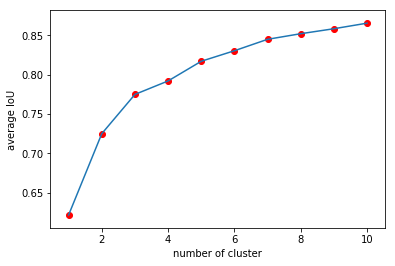

Done!


In [19]:
gen_anchors(n_clusters, uec100_dims)